Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (187473, 28, 28) (187473,)
Validation set (9867, 28, 28) (9867,)
Test set (9788, 28, 28) (9788,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (187473, 784) (187473, 10)
Validation set (9867, 784) (9867, 10)
Test set (9788, 784) (9788, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
def calc_logits(dataset, *layers):
    # variable for the current layer
    activations = dataset
    # apply each layer to the previous
    for i, layer in enumerate(layers):
        activations = tf.matmul(activations, layer[0]) + layer[1]
        # run a ReLU in between each layer, but not on the final layer
        if i < len(layers) - 1:
            activations = tf.nn.relu(activations)
    return activations

In [13]:
batch_size = 128
learning_rate = 0.5

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size ** 2))
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    regul_coeff = tf.placeholder(tf.float32)
    
    weights = tf.Variable(
        tf.truncated_normal([image_size ** 2, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    logits = calc_logits(tf_train_dataset, [weights, biases])
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss += regul_coeff * tf.nn.l2_loss(weights)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(calc_logits(tf_valid_dataset, [weights, biases]))
    test_prediction = tf.nn.softmax(calc_logits(tf_test_dataset, [weights, biases]))
    

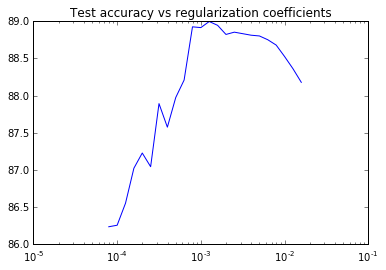

In [14]:
def run(num_steps, regul_coeff_val, verbose=False):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            data = {
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels,
                regul_coeff: regul_coeff_val }
            
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction],
                feed_dict=data)
            
            if verbose and step % 500 == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        
        return accuracy(test_prediction.eval(), test_labels)


regul_coeffs = np.power(10, np.arange(-4.1, -1.7, 0.1), dtype=np.float32)
%time accuracy_vals = [run(3001, regul_coeff) for regul_coeff in regul_coeffs]
plt.semilogx(regul_coeffs, accuracy_vals)
plt.title('Test accuracy vs regularization coefficients')
plt.show()

In [15]:
print('Optimal regularization parameter:')
print(regul_coeffs[np.argmax(accuracy_vals)])

Optimal regularization parameter:
0.00125893


In [16]:
%time run(3001, 2e-3, verbose=True)

Minibatch loss at step 0: 27.143448
Minibatch accuracy: 3.1%
Validation accuracy: 9.8%
Minibatch loss at step 500: 2.719204
Minibatch accuracy: 78.1%
Validation accuracy: 77.1%
Minibatch loss at step 1000: 1.190569
Minibatch accuracy: 81.2%
Validation accuracy: 78.8%
Minibatch loss at step 1500: 0.742051
Minibatch accuracy: 84.4%
Validation accuracy: 81.3%
Minibatch loss at step 2000: 0.658904
Minibatch accuracy: 85.2%
Validation accuracy: 81.6%
Minibatch loss at step 2500: 0.662327
Minibatch accuracy: 89.1%
Validation accuracy: 81.4%
Minibatch loss at step 3000: 0.964299
Minibatch accuracy: 75.0%
Validation accuracy: 82.5%
CPU times: user 9.22 s, sys: 1.62 s, total: 10.8 s
Wall time: 8.46 s


88.904781364936653

In [6]:
batch_size = 128
num_hidden_nodes = 1024
learning_rate = 0.5

graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(batch_size, image_size ** 2))
    tf_train_labels = tf.placeholder(
        tf.float32,
        shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    regul_coeff = tf.placeholder(tf.float32)
    
    weights1 = tf.Variable(
        tf.truncated_normal([image_size ** 2, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
        tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    layers = [
        [weights1, biases1],
        [weights2, biases2]]
    
    logits = calc_logits(tf_train_dataset, *layers)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss += regul_coeff * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(calc_logits(tf_valid_dataset, *layers))
    test_prediction = tf.nn.softmax(calc_logits(tf_test_dataset, *layers))

CPU times: user 1min 4s, sys: 12.4 s, total: 1min 16s
Wall time: 1min 27s


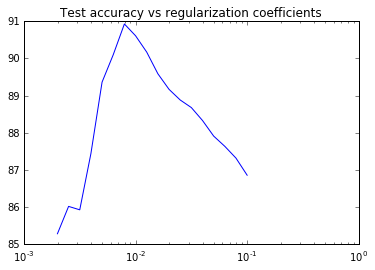

In [22]:
def run(num_steps, regul_coeff_val, verbose=False):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (len(train_labels) - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            data = {
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels,
                regul_coeff: regul_coeff_val }
        
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction],
                feed_dict=data)
            
            if verbose and step % 500 == 0:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                
        return accuracy(test_prediction.eval(), test_labels)
  

regul_coeffs = np.power(10, np.arange(-2.7, -0.9, 0.1), dtype=np.float32)
%time accuracy_vals = [run(501, regul_coeff) for regul_coeff in regul_coeffs]
plt.semilogx(regul_coeffs, accuracy_vals)
plt.title('Test accuracy vs regularization coefficients')
plt.show()

In [23]:
print('Optimal regularization parameter:')
print(regul_coeffs[np.argmax(accuracy_vals)])

Optimal regularization parameter:
0.00794328


In [24]:
%time run(501, 0.00794, verbose=True)

Minibatch loss at step 0: 2817.831055
Minibatch accuracy: 13.3%
Validation accuracy: 27.4%
Minibatch loss at step 500: 46.506756
Minibatch accuracy: 85.9%
Validation accuracy: 84.6%
CPU times: user 3.73 s, sys: 636 ms, total: 4.36 s
Wall time: 4.83 s


91.37719656722517

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
